# COVID-19 in Madrid

## Introduction

On March 13, after the outbreak of COVID-19 in Spain, the central government in Madrid [declared the state of alarm](https://english.elpais.com/society/2020-03-15/spains-state-of-alarm-the-key-measures-that-are-now-in-place.html). Under this state, the movements of citizens will be very limited. This decree will affect the whole of Spain during 15 days although, to be honest, it will probably take longer. Motivated by [previous articles](https://www.businessinsider.com/quarantines-air-pollution-china-but-wont-last-for-long-expert-2020-3?IR=T) on the decreased pollution that has been observed in China, I want to see if our lockdown will have a similar impact in our air quality.

The aim of this project is to analyse air quality parameters day by day since March 12. I am going to extend this project as much as possible, so I can also observe how long it takes us to get Madrid back to our usual pollution levels. My hope is to provide people with enough data to make them think about the impact of our habits in our environment.

Also, this is the perfect chance to get used to Pandas and Matplotlib again, with a little bit of Bash scripting.

## Assessing the air quality

### Materials

I reused an old laptop (Asus EeePC 1001PX) that was lying around in my appartment and installed Lubuntu 16.04.6 LTS.

### Getting the data

I wrote a Bash script (*data_script.sh*) that sends a request to the servers of Madrid city hall to get the daily [air quality data](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=aecb88a7e2b73410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default) as a CSV file.

As I didn't want to do this manually, I added my script to [crontab](https://www.computerhope.com/unix/ucrontab.htm).

### Choose the data

I will primarily focus on famous places such as:

- 28079027 - Barajas
- 28079050 - Plaza de Castilla
- 28079048 - Paseo de la Castellana
- 28079038 - Cuatro Caminos
- 28079035 - Plaza de España
- 28079049 - Retiro
- 28079024 - Casa de Campo
- 28079058 - El Pardo

And the magnitudes to be studied are:

* 1 - SO2
* 6 - CO
* 7 - NO
* 8 - NO2
* 10 - PM10
* 12 - NOx
* 14 - O3
* 44 - NMHC

You can read all the information about this encoding in the PDF file (*Interprete_ficheros_calidad_del_aire_global*). I might choose different magnitudes in the future (basically I just picked them randomly except for NO2). However, I find **Barajas** very interesting as it is close to the airport, which has significantly reduced the number of flights. I am also going to look at NO2 because [traffic and heating systems](https://www.madrid.es/portales/munimadrid/es/Inicio/Servicios-sociales-y-salud/Salud/Dioxido-de-nitrogeno-y-salud/?vgnextfmt=default&vgnextoid=7f9c7fb3af761510VgnVCM2000000c205a0aRCRD&vgnextchannel=0815c8eb248fe410VgnVCM1000000b205a0aRCRD) are the main sources of this pollutant.

Here is a [map](https://www.madrid.es/portales/munimadrid/es/Inicio/Medio-ambiente/Direcciones-y-telefonos/Estaciones-remotas-de-medicion-de-la-calidad-del-aire?vgnextfmt=default&vgnextoid=8c7c2a64e309a110VgnVCM2000000c205a0aRCRD&vgnextchannel=864f79ed268fe410VgnVCM1000000b205a0aRCRD) with all the sampling stations:

![title](mapa_completo_red.jpg)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
import os
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 10)

check_places = {'28079027':'Barajas','28079050':'Plaza de Castilla','28079048':'Pº de la Castellana','28079038':'Cuatro Caminos','28079035':'Plaza de España', '28079049':'Retiro', '28079024':'Casa de Campo', '28079058':'El Pardo'}
measurements = {1:'SO2',6:'CO',7:'NO',8:'NO2',10:'PM10',12:'NOx',14:'O3',44:'NMHC'}
check_times = ['H01','H02','H03','H04','H05','H06','H07','H08','H09','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23']
check_times_peak = ['H07','H08','H09','H10','H18','H19','H20','H21']

hours = range(1,25)

In [2]:
# Merge all the csv files in one data frame
files = glob.glob('air_data/*.csv')

print('There are {} files'.format(len(files)))
days = range(len(files))

df = pd.read_csv(files[0],delimiter=';')
all_data = pd.DataFrame(columns=df.columns)

for f in files:
    df = pd.read_csv(f,delimiter=';')
    all_data = pd.concat([all_data,df])

# Save this new data frame
all_data.to_csv('all_data.csv',index=False)

# Show a preview of the data frame
all_data.head(5)

There are 68 files


,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,8,1,28079008_1_38,2020,3,12,10.0,V,...,8.0,V,8.0,V,9.0,V,0,N,0,N
1,28,79,8,6,28079008_6_48,2020,3,12,1.0,V,...,0.7,V,0.6,V,0.7,V,0,N,0,N
2,28,79,8,7,28079008_7_8,2020,3,12,120.0,V,...,31.0,V,30.0,V,33.0,V,0,N,0,N
3,28,79,8,8,28079008_8_8,2020,3,12,104.0,V,...,86.0,V,85.0,V,92.0,V,0,N,0,N
4,28,79,8,9,28079008_9_47,2020,3,12,34.0,V,...,10.0,V,11.0,V,13.0,V,0,N,0,N


### Analysis

In first place, I just want to plot the average 'amount' of each magnitude (CO, O3, NOx...) and see how they evolve during the lockdown. Another interesting thing to do would be taking just the peak hours (from 7 to 10 in the morning and 6 to 9 in the evening).



Sample: SO2
Barajas
	No data for this sample and location
Plaza de Castilla
	No data for this sample and location
Pº de la Castellana
	No data for this sample and location
Cuatro Caminos
Plaza de España
Retiro
	No data for this sample and location
Casa de Campo
El Pardo
	No data for this sample and location


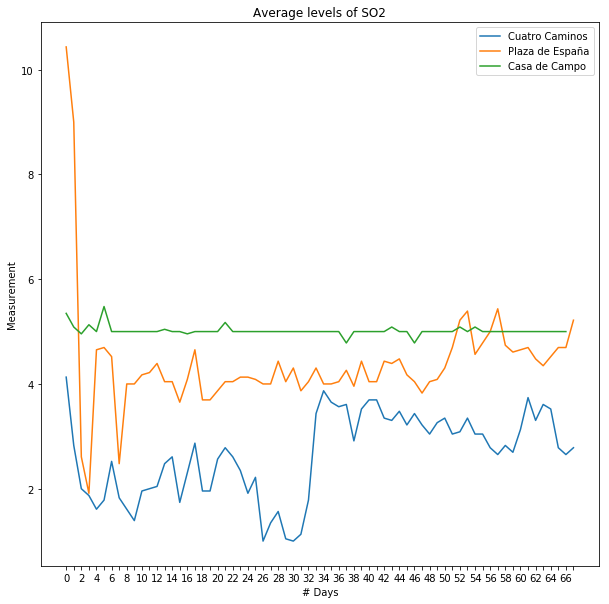



Sample: CO
Barajas
	No data for this sample and location
Plaza de Castilla
	No data for this sample and location
Pº de la Castellana
	No data for this sample and location
Cuatro Caminos
	No data for this sample and location
Plaza de España
Retiro
	No data for this sample and location
Casa de Campo
El Pardo
	No data for this sample and location


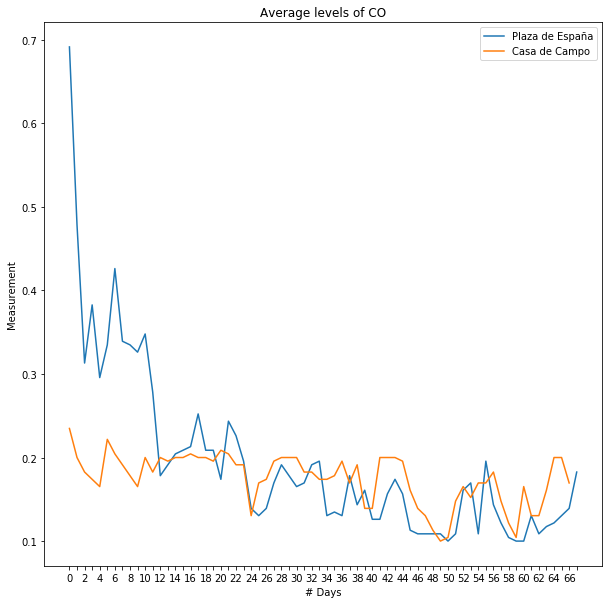



Sample: NO
Barajas
Plaza de Castilla
Pº de la Castellana
Cuatro Caminos
Plaza de España
Retiro
Casa de Campo
El Pardo


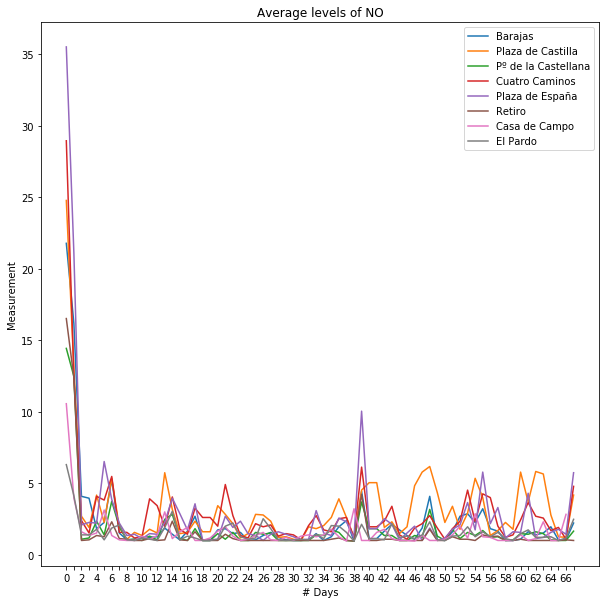



Sample: NO2
Barajas
Plaza de Castilla
Pº de la Castellana
Cuatro Caminos
Plaza de España
Retiro
Casa de Campo
El Pardo


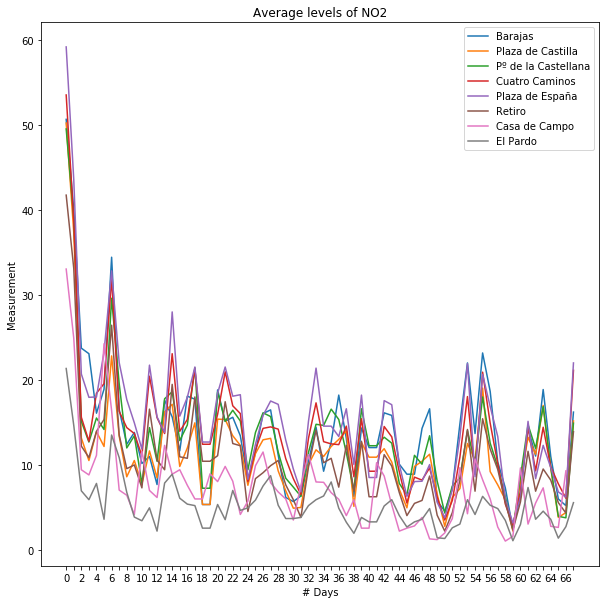



Sample: PM10
Barajas
	No data for this sample and location
Plaza de Castilla
Pº de la Castellana
Cuatro Caminos
Plaza de España
	No data for this sample and location
Retiro
	No data for this sample and location
Casa de Campo
El Pardo
	No data for this sample and location


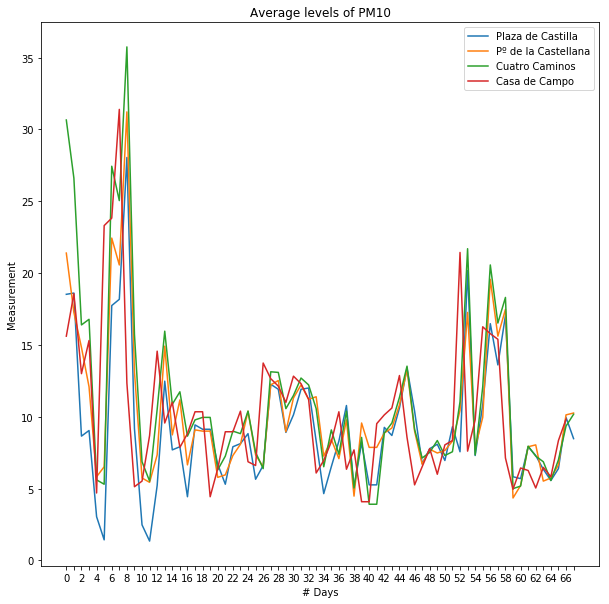



Sample: NOx
Barajas
Plaza de Castilla
Pº de la Castellana
Cuatro Caminos
Plaza de España
Retiro
Casa de Campo
El Pardo


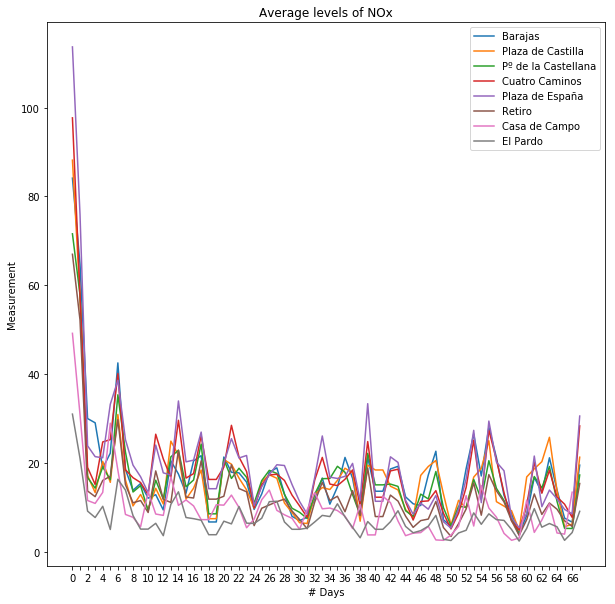



Sample: O3
Barajas
Plaza de Castilla
	No data for this sample and location
Pº de la Castellana
	No data for this sample and location
Cuatro Caminos
	No data for this sample and location
Plaza de España
Retiro
Casa de Campo
El Pardo


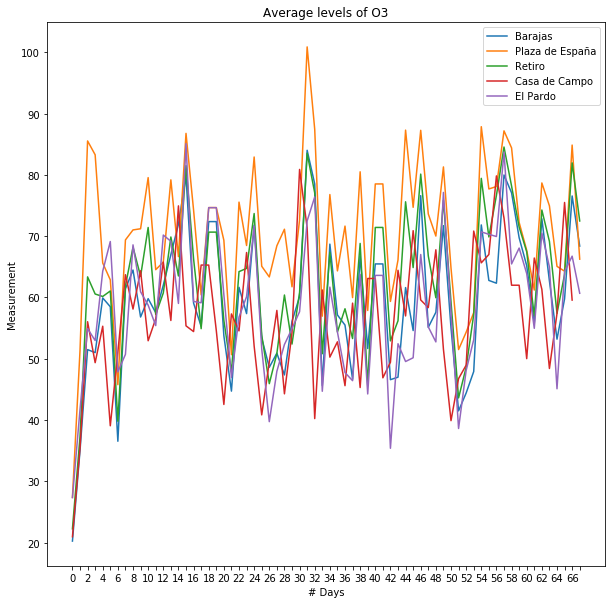



Sample: NMHC
Barajas
	No data for this sample and location
Plaza de Castilla
	No data for this sample and location
Pº de la Castellana
	No data for this sample and location
Cuatro Caminos
	No data for this sample and location
Plaza de España
	No data for this sample and location
Retiro
	No data for this sample and location
Casa de Campo
El Pardo
	No data for this sample and location


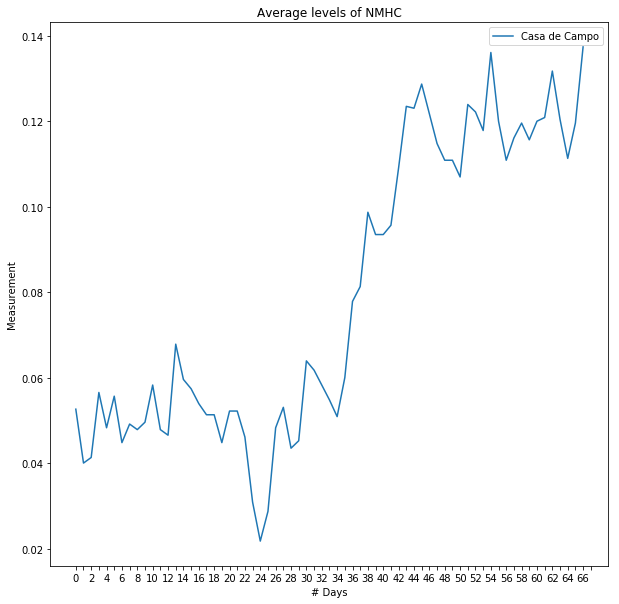

In [3]:
# Plotting the average value for each day
matplotlib.rcParams['figure.figsize'] = (10, 10)

for m_code,m_name in measurements.items():
    days_m = []
    places = []
    print('\n\nSample: ' + m_name)
    for code, location in check_places.items():
        print(location)
        df = all_data.loc[(all_data['MAGNITUD']==m_code) & (all_data['PUNTO_MUESTREO'].str.contains(code))].copy()
        
        if df.shape[0] != 0:
            # Get the total days
            df.sort_values(['MES','DIA'])
            df = df.reset_index()
            df['NUMDIA'] = df.index
            days_m = df['NUMDIA'].copy()
            
            all_times = df[check_times].copy()
            for t in check_times:
                all_times[t] = pd.to_numeric(all_times[t])
            all_times['MEDIO'] = all_times.mean(axis=1)
            plt.plot(df['NUMDIA'],all_times['MEDIO'])
            places.append(location)
        else:
            print('\tNo data for this sample and location')
    
    if len(places)>0:
        plt.legend(places)
        plt.xticks(days)
        plt.xlabel('# Days')
        plt.ylabel('Measurement')
        plt.title('Average levels of '+m_name)
        ax = plt.gca()
        for label in ax.get_xaxis().get_ticklabels()[1::2]:
            label.set_visible(False)
        plt.show()



Sample: SO2
Barajas
	No data for this sample and location
Plaza de Castilla
	No data for this sample and location
Pº de la Castellana
	No data for this sample and location
Cuatro Caminos
Plaza de España
Retiro
	No data for this sample and location
Casa de Campo
El Pardo
	No data for this sample and location


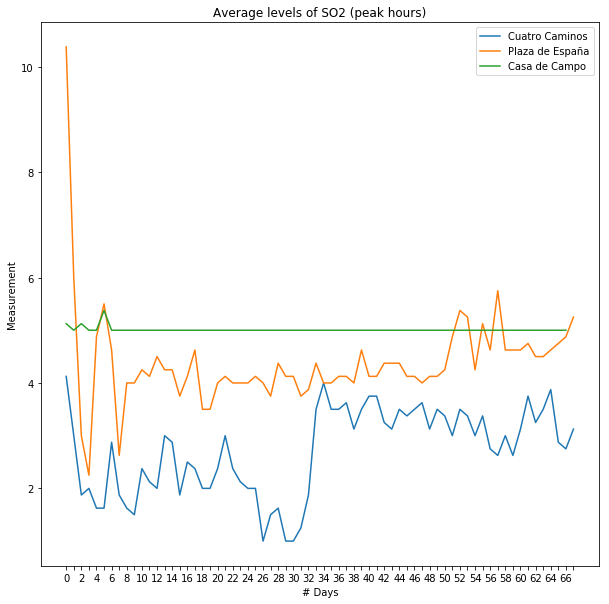



Sample: CO
Barajas
	No data for this sample and location
Plaza de Castilla
	No data for this sample and location
Pº de la Castellana
	No data for this sample and location
Cuatro Caminos
	No data for this sample and location
Plaza de España
Retiro
	No data for this sample and location
Casa de Campo
El Pardo
	No data for this sample and location


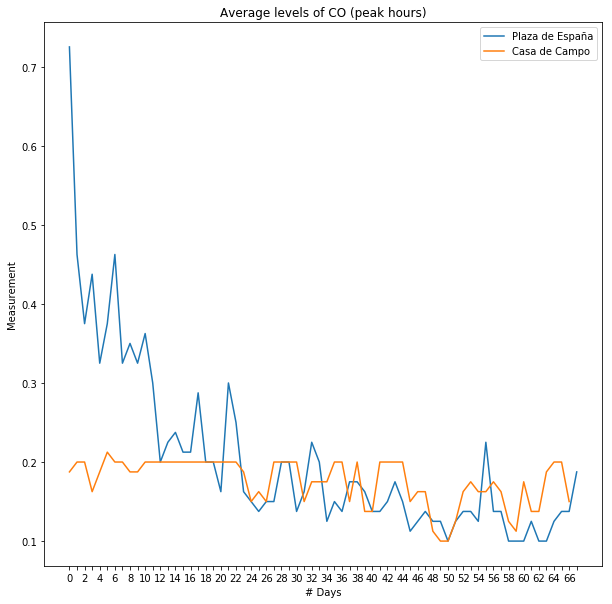



Sample: NO
Barajas
Plaza de Castilla
Pº de la Castellana
Cuatro Caminos
Plaza de España
Retiro
Casa de Campo
El Pardo


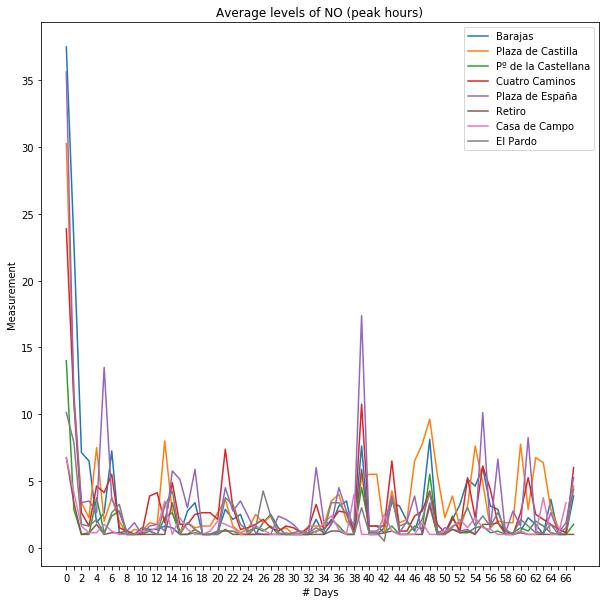



Sample: NO2
Barajas
Plaza de Castilla
Pº de la Castellana
Cuatro Caminos
Plaza de España
Retiro
Casa de Campo
El Pardo


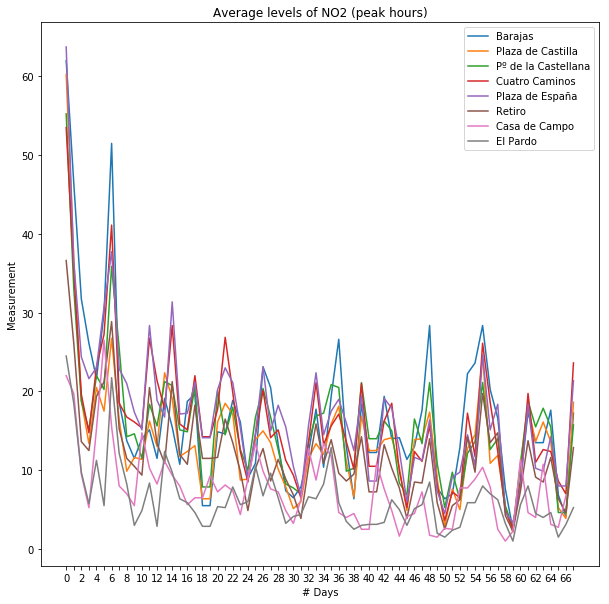



Sample: PM10
Barajas
	No data for this sample and location
Plaza de Castilla
Pº de la Castellana
Cuatro Caminos
Plaza de España
	No data for this sample and location
Retiro
	No data for this sample and location
Casa de Campo
El Pardo
	No data for this sample and location


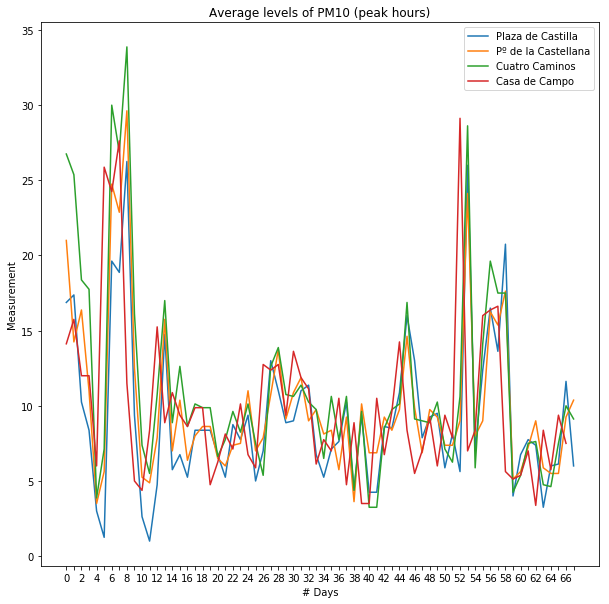



Sample: NOx
Barajas
Plaza de Castilla
Pº de la Castellana
Cuatro Caminos
Plaza de España
Retiro
Casa de Campo
El Pardo


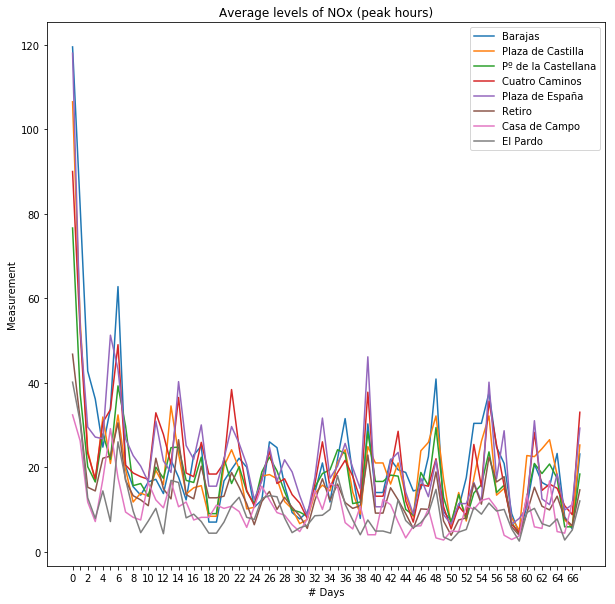



Sample: O3
Barajas
Plaza de Castilla
	No data for this sample and location
Pº de la Castellana
	No data for this sample and location
Cuatro Caminos
	No data for this sample and location
Plaza de España
Retiro
Casa de Campo
El Pardo


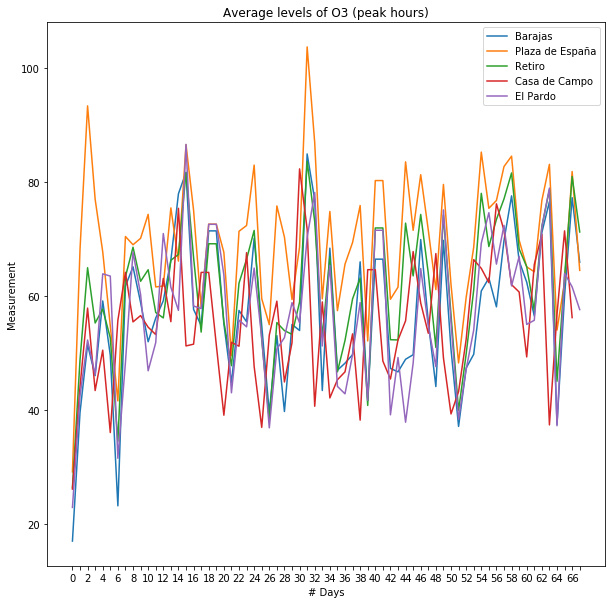



Sample: NMHC
Barajas
	No data for this sample and location
Plaza de Castilla
	No data for this sample and location
Pº de la Castellana
	No data for this sample and location
Cuatro Caminos
	No data for this sample and location
Plaza de España
	No data for this sample and location
Retiro
	No data for this sample and location
Casa de Campo
El Pardo
	No data for this sample and location


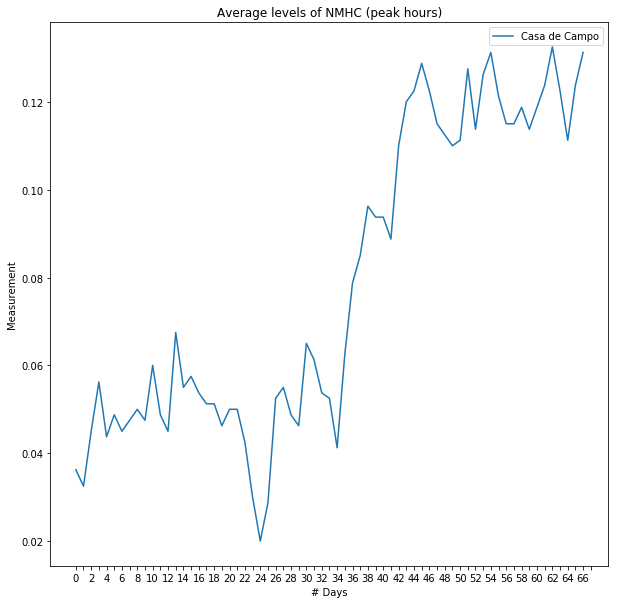

In [4]:
# Plotting the average value for each day DURING PEAK TIMES
matplotlib.rcParams['figure.figsize'] = (10, 10)

for m_code,m_name in measurements.items():
    days_m = []
    places = []
    print('\n\nSample: ' + m_name)
    for code, location in check_places.items():
        print(location)
        df = all_data.loc[(all_data['MAGNITUD']==m_code) & (all_data['PUNTO_MUESTREO'].str.contains(code))].copy()
        
        if df.shape[0] != 0:
            # Get the number of days
            df.sort_values(['MES','DIA'])
            df = df.reset_index()
            df['NUMDIA'] = df.index
            days_m = df['NUMDIA'].copy()
            
            all_times = df[check_times_peak].copy()
            for t in check_times_peak:
                all_times[t] = pd.to_numeric(all_times[t])
            all_times['MEDIO'] = all_times.mean(axis=1)
            plt.plot(df['NUMDIA'],all_times['MEDIO'])
            places.append(location)
        else:
            print('\tNo data for this sample and location')
    
    if len(places)>0:
        plt.legend(places)
        plt.xticks(days)        
        plt.xlabel('# Days')
        plt.ylabel('Measurement')
        plt.title('Average levels of ' + m_name + ' (peak hours)')
        ax = plt.gca()
        for label in ax.get_xaxis().get_ticklabels()[1::2]:
            label.set_visible(False)
        plt.show()